# goes-orthorectify

Orthorectify and clip a GOES ABI image using the mapping created by goes-make-orth-map

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#import warnings
#warnings.filterwarnings('ignore')

#### Open a GOES-16 image

In [5]:
image_path = r'\\j-lundquist-3.ce.washington.edu\storage\GOES\goes16\2017\03\1\ABI-L1b-RadC\00\C14\OR_ABI-L1b-RadC-M3C14_G16_s20170600002497_e20170600005270_c20170600005307.nc'

In [6]:
image = xr.open_dataset(image_path)
image.x

<xarray.DataArray 'x' (x: 2500)>
array([-0.075012, -0.074956, -0.0749  , ...,  0.06482 ,  0.064876,  0.064932],
      dtype=float32)
Coordinates:
    t        datetime64[ns] ...
  * x        (x) float32 -0.075012 -0.074956 -0.0749 ... 0.064876005 0.064932
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    units:          rad
    axis:           X
    long_name:      GOES fixed grid projection x-coordinate
    standard_name:  projection_x_coordinate

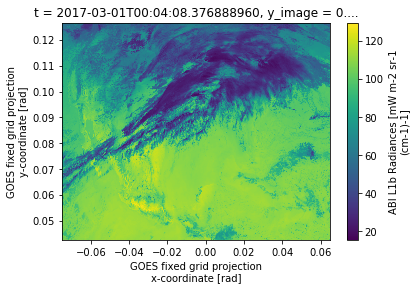

In [7]:
image.Rad.plot()

#### Open the ortho mapping:

In [8]:
tuol_test = xr.open_dataset('test_map_tuol.nc')
print(tuol_test)

<xarray.Dataset>
Dimensions:              (x: 1995, y: 1501)
Coordinates:
    longitude            (x) float64 ...
    latitude             (y) float64 ...
Dimensions without coordinates: x, y
Data variables:
    abi_500m_px_angle_x  (y, x) float64 ...
    abi_500m_px_angle_y  (y, x) float64 ...
    abi_1km_px_angle_x   (y, x) float64 ...
    abi_1km_px_angle_y   (y, x) float64 ...
    abi_2km_px_angle_x   (y, x) float64 ...
    abi_2km_px_angle_y   (y, x) float64 ...
    dem_px_angle_x       (y, x) float64 ...
    dem_px_angle_y       (y, x) float64 ...
    elevation            (y, x) float64 ...
Attributes:
    longitude_of_projection_origin:                 -89.5
    semi_major_axis:                                6378137
    semi_minor_axis:                                6356752.31414
    perspective_point_height+semi_major_axis:       42164160
    grs80_eccentricity:                             0.0818191910435
    longitude_of_projection_origin_info:            longitude of geost

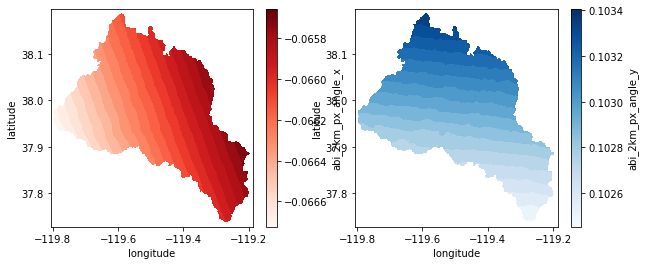

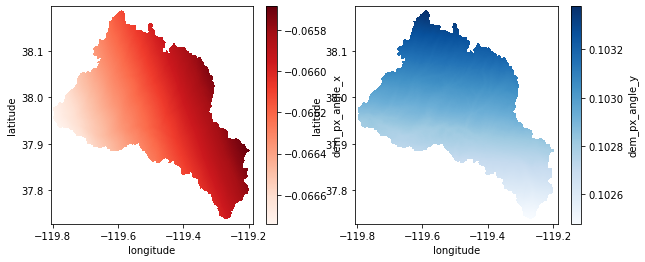

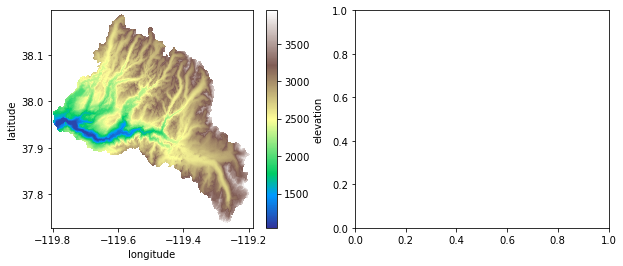

In [9]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
tuol_test.abi_2km_px_angle_x.plot(x='longitude',y='latitude',cmap='Reds',ax=ax[0])
tuol_test.abi_2km_px_angle_y.plot(x='longitude',y='latitude',cmap='Blues',ax=ax[1])

fig, ax = plt.subplots(1,2,figsize=(10,4))
tuol_test.dem_px_angle_x.plot(x='longitude',y='latitude',cmap='Reds',ax=ax[0])
tuol_test.dem_px_angle_y.plot(x='longitude',y='latitude',cmap='Blues',ax=ax[1])

fig, ax = plt.subplots(1,2,figsize=(10,4))
tuol_test.elevation.plot(x='longitude',y='latitude',cmap='terrain',ax=ax[0])

#### Map and clip the image to the pixel map

<xarray.DataArray 'abi_2km_px_angle_x' ()>
array(-0.066332)
Coordinates:
    longitude  float64 ...
    latitude   float64 ... <xarray.DataArray 'abi_2km_px_angle_y' ()>
array(0.1029)
Coordinates:
    longitude  float64 ...
    latitude   float64 ...
<xarray.DataArray 'y' (y: 1)>
array([0.1029], dtype=float32)
Coordinates:
    t        datetime64[ns] ...
  * y        (y) float32 0.1029
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    units:          rad
    axis:           Y
    long_name:      GOES fixed grid projection y-coordinate
    standard_name:  projection_y_coordinate
<xarray.DataArray 'x' (x: 1)>
array([-0.066332], dtype=float32)
Coordinates:
    t        datetime64[ns] ...
  * x        (x) float32 -0.066332
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    units:          rad
    axis:           X
    long_name:      GOES fixed grid projection x-coordinate
    standard_name:  projection_x_coordinate


(<xarray.DataArray 'abi_2km_px_angle_y' ()>
 array(0.0929)
 Coordinates:
     longitude  float64 ...
     latitude   float64 ..., <xarray.DataArray 'abi_2km_px_angle_y' ()>
 array(0.1129)
 Coordinates:
     longitude  float64 ...
     latitude   float64 ...)

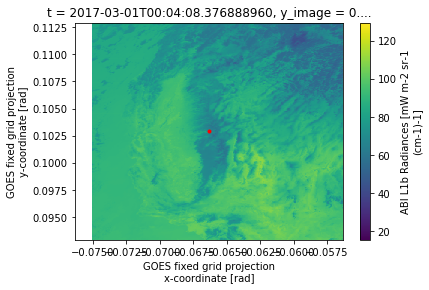

In [10]:
x = 700
y = 700
abi_x = tuol_test.abi_2km_px_angle_x[y,x]
abi_y = tuol_test.abi_2km_px_angle_y[y,x]
print(abi_x,abi_y)
print(image.y[image.y==abi_y.values])
print(image.x[image.x==abi_x.values])
image.Rad.plot()
plt.plot(abi_x,abi_y,'.r')
plt.xlim((abi_x-0.01, abi_x+0.01))
plt.ylim((abi_y-0.01, abi_y+0.01))

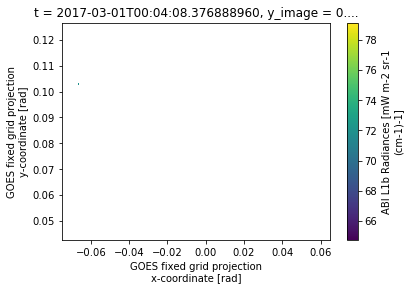

In [11]:
image.Rad.where((image.Rad.y==abi_y.values) & (image.Rad.x==abi_x.values)).plot()

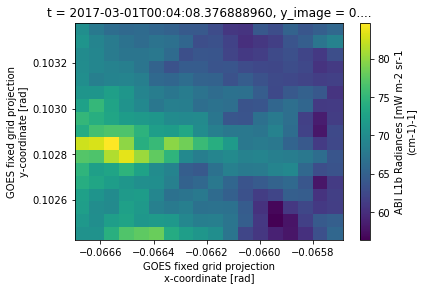

In [12]:
# find X coordinates (ABI Fixed Grid scan angle coordinates)
x_condition = (image.x >= tuol_test.abi_2km_px_angle_x.min()) & (image.x <= tuol_test.abi_2km_px_angle_x.max())
# find Y coordinates (ABI Fixed Grid scan angle coordinates)
y_condition = (image.y >= tuol_test.abi_2km_px_angle_y.min()) & (image.y <= tuol_test.abi_2km_px_angle_y.max())
# Plot the result (this is clipped around our DEM area)
image.Rad[y_condition,x_condition].plot()

(<xarray.DataArray 'abi_2km_px_angle_y' ()>
 array(0.102452), <xarray.DataArray 'abi_2km_px_angle_y' ()>
 array(0.103404))

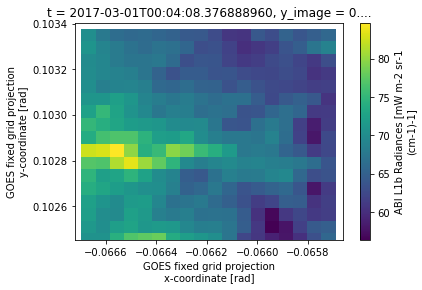

In [14]:
# find X coordinates (ABI Fixed Grid scan angle coordinates)
x_condition = (image.x >= tuol_test.abi_2km_px_angle_x.min()) & (image.x <= tuol_test.abi_2km_px_angle_x.max())
# find Y coordinates (ABI Fixed Grid scan angle coordinates)
y_condition = (image.y >= tuol_test.abi_2km_px_angle_y.min()) & (image.y <= tuol_test.abi_2km_px_angle_y.max())
# Plot the result (this is clipped around our DEM area)
image.Rad.where((x_condition) & (y_condition)).plot()
plt.xlim((tuol_test.abi_2km_px_angle_x.min(),tuol_test.abi_2km_px_angle_x.max()))
plt.ylim((tuol_test.abi_2km_px_angle_y.min(),tuol_test.abi_2km_px_angle_y.max()))

***
***